# 4. 이벤트 드리븐 전략

## (1) KoNLPy 설치
- KoNLPy는 한국어 정보처리를 위한 Python library이다.
- 커뮤니티 및 관련 정보는 아래 사이트에서 확인 가능하다.
    - Homepage : https://konlpy.org/ko/ 
    - Github : https://github.com/bukosabino/ta
- 해당 package 내 분석기를 사용하기 위해 jvm(jdk) 설치 필요: https://konlpy.org/ko/latest/install/#id2

In [1]:
# ! pip install konlpy

- 매일경제 사이트를 통해 뉴스 제목 데이터 수집을 위한 Package beautifulsoup4, seleinum, webdriver_manager 설치: 주어진 데이터 사용 시, 설치 미필요

In [2]:
# ! pip install beautifulsoup4
# ! pip install selenium
# ! pip install webdriver_manager

## (2) 데이터 가져오기
- 매일경제 사이트를 통해 원하는 키워드의 뉴스 제목 수집. 제공된 데이터 사용 시, 수집 미진행
    - Homepage: https://www.mk.co.kr/     

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ActionChains

from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import datetime
import os


In [4]:
# 삼성전자 주가 데이터

data_samsung = pd.read_csv(r'005930.KS.csv', index_col=0)
data_samsung.columns=['open','high', 'low', 'close_not_adjusted', 'close', 'volume']
data_samsung

,open,high,low,close_not_adjusted,close,volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.727783,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.858887,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.599365,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.100586,46880000
...,...,...,...,...,...,...
2024-06-26,80100.0,81400.0,79900.0,81300.0,81300.000000,17783242
2024-06-27,81300.0,81600.0,80500.0,81600.0,81600.000000,11739720
2024-06-28,81900.0,81900.0,80800.0,81500.0,81500.000000,9455929


In [5]:
# 삼성전자 관련 뉴스 데이터 

fname = './news_005630.csv'                                           # 뉴스 데이터 파일명

keyword ='삼성전자'                                                    # 검색 키워드
startdate = datetime.datetime.strptime('2000-01-01', "%Y-%m-%d")      # 수집 시작 일자
enddate = startdate + datetime.timedelta(days=1)


In [6]:
if os.path.exists(fname):    
    # 데이터 파일이 있는 경우

    df_news = pd.read_csv(fname, index_col=0)
else:
    # 데이터 파일이 없는 경우, 수집 진행

    news = []

    serv = Service(ChromeDriverManager().install())
    chromeOptions = webdriver.ChromeOptions()
    chromeOptions.add_argument('--headless')
    chromeOptions.add_argument('--no-sandbox')
    chromeOptions.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(service=serv, options=chromeOptions)

    while enddate < datetime.datetime.strptime('2024-07-01', "%Y-%m-%d"): # 2024년 7월 1일까지 수집 진행
        startdate_str = datetime.datetime.strftime(startdate, "%Y-%m-%d")
        enddate_str = datetime.datetime.strftime(enddate, "%Y-%m-%d")
        url = f'https://www.mk.co.kr/search?word={keyword}&dateType=direct&startDate={startdate_str}&endDate={enddate_str}&searchField=title' # 매일경제 내 해당 키워드 및 일자 뉴스 검색
        driver.get(url)

        n_news = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[2]/main/section/div/div[2]/div/div/div[1]/section/header/div[1]/h2/span'))).text # 검색된 뉴스 개수
        if n_news != '':

            soup = bs(driver.page_source, 'html.parser')
            news_date = soup.find_all("div", {"class": "txt_area"})

            while len(news_date) < int(n_news):
                try :
                    button = driver.find_element(By.CSS_SELECTOR, f'#all_cnt > div > div.col.main_col > section > div > div > div > button')                        
                    actions = ActionChains(driver).move_to_element(button)
                    actions.perform()
                    button.click()
                except:
                    time.sleep(1)

                soup = bs(driver.page_source, 'html.parser')
                news_date = soup.find_all("div", {"class": "txt_area"})
            
            # 뉴스 날짜 및 제목 추출
            news.extend([[n.find("div", {"class": "info_group"}).find("p", {"class": "time_info"}).text, n.find("h3", {"class": "news_ttl"}).text] for n in news_date])
            

        startdate = startdate + datetime.timedelta(days=1)
        enddate = enddate + datetime.timedelta(days=1)
        
    driver.quit()

    df_news = pd.DataFrame(news, columns=['date', 'title'])
    df_news.to_csv(fname)

In [7]:
df_news

,date,title
0,2000.01.02 12:21,[전문가 추천 유망종목] 삼성전자
1,2000.01.03 15:41,굿모닝증권 삼성전자 등 투자유망 40선 선정
2,2000.01.03 13:31,"와이즈소프트, 삼성물산 유투존 전자상거래 구축"
3,2000.01.03 11:50,"삼성전자, 세계서 가장 빠른 288메가급 램버스D램 개발"
4,2000.01.04 18:54,[공시] 데이콤/현대미포조선/이수화학/삼성전자
...,...,...
26414,2024.06.30 20:06,"EU, 구글-삼성전자 겨냥 'AI 협력' 반독점 조사 검토"
26415,2024.06.30 15:40,"“부모님 관리, 스마트싱스로”…삼성전자 ‘패밀리 케어’ 서비스"
26416,2024.06.30 13:00,재용이형 대신 의선이형...취준생 선택은 삼성전자 아닌 현대차
26417,2024.07.01 22:14,삼성전자 노조 “요구 관철될 때까지 無임금·無노동 파업”


## (3) 이벤트 키워드 추출 
- Konlpy를 통해 전체 뉴스에 대한 이벤트 키워드(명사 단어) 추출을 진행한다.

In [8]:
# Konlpy 불러오기 및 분석기 okt 불러오기
import numpy as np
from konlpy.tag import *

okt=Okt() 

In [9]:
# okt를 이용하여 품사 태깅 및 명사 추출
news_noun = []

for idx, row in df_news.iterrows():
    news_noun.append([row['date'], okt.nouns(row['title']), row['title']])    

## (4) 제안 매매 알고리즘
- n일 후 가격이 상승할 것이라 예측되는 명사 단어(이벤트)가 발생하는 경우, 다음날 매수를 진행하여 n일 간 보유하는 알고리즘을 구현한다.
- train 기간(2010~2019)의 데이터로 명사 단어(이벤트)와 n일 후 수익률 관계를 파악하고, validation 기간(2020~2021)의 데이터로 수익률이 높은 최적의 n값 및 해당하는 명사 단어(이벤트)를 선정하고, test 기간(2022~2023)의 데이터로 성능 평가를 진행한다.

In [10]:
# 뉴스 데이터 분리
t1, t2, t3, t4 = '2010', '2020', '2022', '2024'

news_noun_train = [row for row in news_noun if (row[0]>=t1) & (row[0]<t2)]
news_noun_valid = [row for row in news_noun if (row[0]>=t2) & (row[0]<t3)]
news_noun_test = [row for row in news_noun if (row[0]>=t3) & (row[0]<t4)]

In [11]:
# n일 후 return을 계산한 후 데이터 분리
n_return = 20
for n in range(1, n_return+1):
    data_samsung[f'return_{n}'] = data_samsung['close'].pct_change(n).shift(-n)

df_train = data_samsung.loc[(data_samsung.index >= t1) & (data_samsung.index < t2), ['close']+ [f'return_{n}' for n in range(1, n_return+1)]].dropna(axis=0)    # n일 전 가격을 알 수 없는 초반 일자(nan 값 존재 일자) 제거
df_valid = data_samsung.loc[(data_samsung.index >= t2) & (data_samsung.index < t3), ['close']+ [f'return_{n}' for n in range(1, n_return+1)]]
df_test = data_samsung.loc[(data_samsung.index >= t3) & (data_samsung.index < t4), ['close']+ [f'return_{n}' for n in range(1, n_return+1)]].dropna(axis=0)        # 익일 가격을 알 수 없는 마지막 일자 제거

### 1) train: train 기간의 뉴스 와 n일 후 return
- 이때, 1자 단어(e.g. 권, 황) 및 중립적 단어(e.g. 휴대전화, 단말기)는 제외하고 train 기간에 충분히(즉, 10회 초과) 발생한 단어만 선정하여 학습이 적절하게 이루어지도록 한다.

In [12]:
# 추출된 명사 단어 및 발생 횟수 계산

keywords_train = []
for row in news_noun_train:
    keywords_train.extend(row[1])

event_train, event_count_train = np.unique(keywords_train, return_counts=True)
event_train, event_count_train

(array(['가가', '가게', '가격', ..., '힘', '힘겨루기', '힙'], dtype='<U7'),
 array([ 1,  1, 40, ..., 30,  1,  2]))

In [13]:
# 적절한 분석을 위해, train 기간 내 10회 초과로 발생한 단어 중에서 선정하고 1자 단어 및 중립 단어는 제외한다.

thres_count = 10
event_all_train = [[str(row[0]), int(row[1])] for row in zip(event_train, event_count_train) if (row[1] > thres_count) & (len(row[0]) > 1)] # 10회 초과 발생한 단어 선정

keywords_neutral = ['권', '황', '이슈', '금', '설', '핏', '팀', '관', '휴대전화', '단말기', '뉴', '추석', '이', '홈', '칸', '화학', '계획', '스타',
                    '블랙베리', '최신', '반영', '스포크', '오늘', '전문가', '휴대폰',] # 중립 단어 리스트

In [14]:
# 명사 단어(이벤트)별 발생 n일 후 평균 수익률을 계산한다

df_event_return_count = pd.DataFrame(columns=['event', 'count'] + [f'return_{n}' for n in range(1, n_return+1)])

for event, cnt in event_all_train:
    news_event = [row for row in news_noun_train if event in row[1]]
    news_dates = [row[0][:10].replace('.', '-') for row in news_event]
    
    row_event = [event, cnt] + data_samsung.loc[data_samsung.index.isin(news_dates), [f'return_{n}' for n in range(1, n_return+1)]].mean(axis=0).values.tolist()
    df_event_return_count.loc[len(df_event_return_count)] = row_event


### 2) validation: train을 통해 구한 이벤트 별 n일 후 수익률 데이터를 활용하여, validation 기간에 좋은 성능을 내는 최적의 상위 데이터 개수(ne) 및 수익률 계산 일 수(nd) 조합을 구한다.

In [15]:
################ 전략 파라미터 ##############
num_of_days_list = [n for n in range(3, n_return+1)]
num_of_events_list = [n for n in range(3, 11)]
################ 전략 파라미터 ##############

valid_results = pd.DataFrame(columns=['events', 'num_of_events', 'num_of_days', 'return', 'num_of_bids'])

for nd in num_of_days_list:
    for ne in num_of_events_list:
        ################ 백테스팅 파라미터 #############
        holding_cash = 1_000_000 # 보유 현금
        position = 0 # 현재 보유 포지션
        avg_price = 0 # 평단가
        daily_total_value = [] #일별 총 포트폴리오 가치
        slippage = 0.0025 # 슬리피지 
        ################ 백테스팅 파라미터 #############

        # nd일 기준, 수익률 상위 nd개 추출(1자 단어 및 중립 단어 제외)
        event_list = df_event_return_count.loc[~df_event_return_count.event.isin(keywords_neutral)].sort_values(by=f'return_{nd}').iloc[-ne:]['event'].values.tolist()

        days = -1
        n_bid = 0

        # 한 row 씩 루프
        for idx, row in df_valid.iterrows():

            daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
            news_today = [news_today_noun for news_today_noun in news_noun_valid if news_today_noun[0][:10].replace('.', '-') == row.name] # 해당 날짜에 발생한 뉴스 이벤트 추출
            
            event_today = []
            for _, noun_today, title_today in news_today:
                event_today.extend(noun_today)
            event_today = list(set(event_today))
            
            
            # 매수: 전날 뉴스에 이벤트 키워드가 포함된 경우
            if (position == 0) and (days == 1):
                # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
                position = int(holding_cash / row['close'])
                holding_cash -= position * row['close']
                avg_price = row['close']
                n_bid += 1

            # 매도: 최근 기사에 이벤트 키워드가 포함되지 않고 최종 뉴스 발생에서 nd일이 지난 경우
            elif (position > 0) and (days > nd):
                holding_cash += (position * row['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
                position = 0
                avg_price = 0
                days = -1

            # 날짜 업데이트: 전날 뉴스에 이벤트 키워드가 포함된 경우, 날짜 count reset
            for event in event_today:
                if event in event_list:
                    days = 0
                
            if days > -1:
                days += 1

            daily_total_value[-1]+= holding_cash+ position* row['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산
            

        valid_results.loc[len(valid_results)] = [event_list, ne, nd, daily_total_value[-1]/1_000_000, n_bid]

In [16]:
# 수익률 기준 상위권 성능 조합
valid_results.sort_values(by='return', ascending=False).iloc[:10]

,events,num_of_events,num_of_days,return,num_of_bids
79,"[바닥, 업무, 전국, 의료기기, 녹색, 하만, 컨퍼런스, 루프, 어닝쇼크, 박상진]",10,12,1.504733,13
78,"[업무, 전국, 의료기기, 녹색, 하만, 컨퍼런스, 루프, 어닝쇼크, 박상진]",9,12,1.365540,10
50,"[바닥, 전국, 박상진, 어닝쇼크, 동결]",5,9,1.186875,9
55,"[장외, 의료기기, 시안, 해결, 취득, 바닥, 전국, 박상진, 어닝쇼크, 동결]",10,9,1.179005,12
54,"[의료기기, 시안, 해결, 취득, 바닥, 전국, 박상진, 어닝쇼크, 동결]",9,9,1.179005,12
53,"[시안, 해결, 취득, 바닥, 전국, 박상진, 어닝쇼크, 동결]",8,9,1.179005,12
94,"[장주, 퇴직, 하만, 컨퍼런스, 한계, 녹색, 전국, 박상진, 어닝쇼크]",9,14,1.176189,8
85,"[한계, 누적, 하만, 컨퍼런스, 전국, 녹색, 박상진, 어닝쇼크]",8,13,1.166300,7
84,"[누적, 하만, 컨퍼런스, 전국, 녹색, 박상진, 어닝쇼크]",7,13,1.166300,7
47,"[합의, 제한, 바닥, 견인, 시안, 취득, 해결, 전국, 어닝쇼크, 박상진]",10,8,1.156157,14


### 3) Test: 최종 모델을 통해 매매하는 전략의 성능을 평가한다.

{'하만', '업무'} return= -0.041 ['車전장 힘싣는 삼성전자…하만 `獨 AR벤처` 품었다', '삼성전자·한전 업무협약, 아파트 에너지 실시간 관리']
{'바닥'} return= 0.019 ['바닥찍은 줄 알았더니…삼성전자, 사흘 만에 또 신저가', '삼성전자, 외국인 귀환에 4%↑…증권가 "주가 바닥권 진입"']
{'의료기기', '바닥', '녹색'} return= 0.034 ['6만원선 깨지자 연일 바닥기는 삼성전자…목표가도 줄하향', '10만전자 꿈꾸던 국민주, 바닥은 어디?  삼성전자, 전망은 좋지만 4만전자 갈 수도', '“삼성전자 바닥 확인했다”…KB證 “장기 투자에 매력적인 가격”', '"삼성전자 주가 바닥 확인…장기 투자 매력적" KB증권', '"삼성전자 주가 바닥 가격 확인"...비중확대는 DSR무관 연4.95% 자금으로', '[빅데이터로 본 재테크] 삼성전자, 실적 선방에 이달 주가 8% 반등…바닥 다졌나', '삼성전자, `올해의 녹색상품` 대거 선정…의료기기 첫 포함', '삼성전자, `올해의 녹색상품` 대거 선정…의료기기 첫 포함']
{'바닥'} return= -0.008 ['바닥찍고 이제 오르나 했는데…삼성전자 3% 안팎 하락, 전날 상승분 반납']
{'어닝쇼크'} return= 0.074 ['‘반도체 한파’ 삼성전자 어닝쇼크…영업이익 전년 대비 31.7%↓']
{'어닝쇼크', '바닥'} return= 0.076 ['“삼성전자, 주가 바닥권 수준…비중 확대 기회” 키움증권', '“삼성전자 주가 바닥권, 비중확대 기회”…대비는 DSR무관 재원으로', '삼성전자, 역대급 어닝쇼크에도 주가 선방...‘6만전자’ 성큼', '“어닝쇼크가 호재?”…삼성전자 부진한 실적에도 주가 쑥', '“6만전자 멀어지나”...삼성전자, 역대급 어닝쇼크에 주가 약세', '실적 바닥찍고 반등하나…보고서 10개중 6개가 삼성전자 [빅데이터로 본 재테크]', '‘어닝쇼크’ 맞은 삼성전자 주가 약세…감산카드 꺼낼까', '삼성전자 ‘어닝쇼크’…반도체 4분기 영업

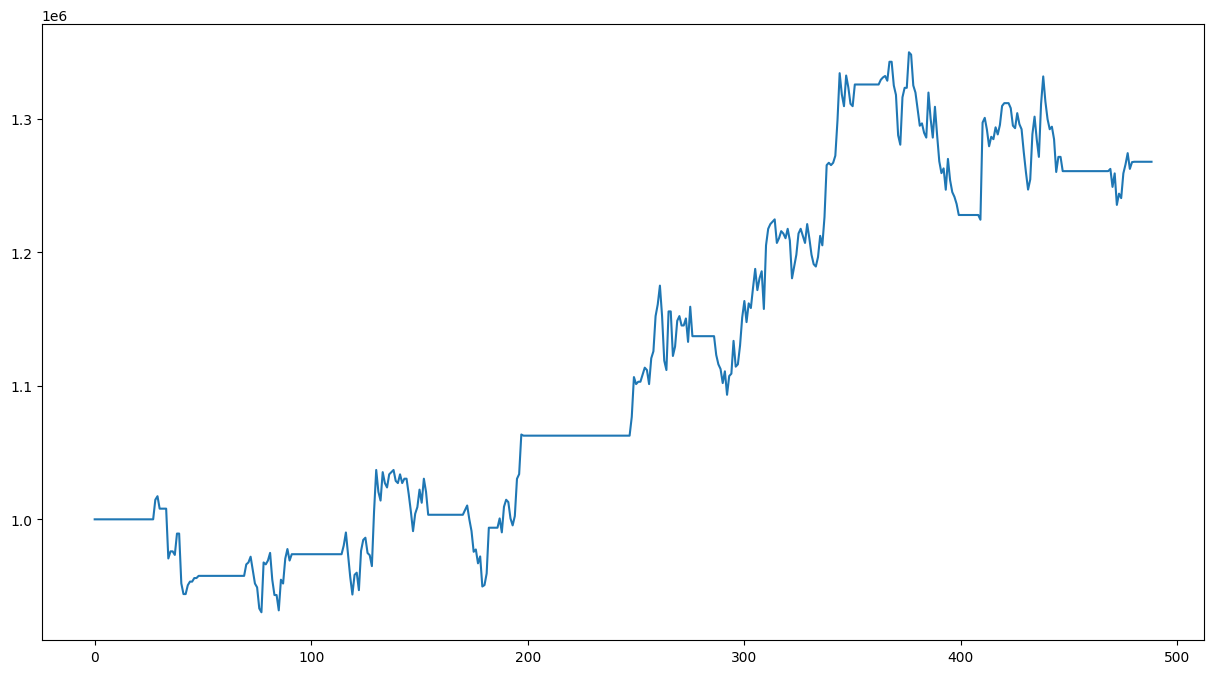

In [17]:
################ 백테스팅 파라미터 #############
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
daily_total_value = [] #일별 총 포트폴리오 가치
slippage = 0.0025 # 슬리피지 
################ 백테스팅 파라미터 #############

event_list, ne, nd, _, _ = valid_results.sort_values(by='return', ascending=False).iloc[0]

days = -1
n_bid = 0

trade_history = []
last_trade = [[], [], 1]
# 한 row 씩 루프
for idx, row in df_test.iterrows():

    daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가
    news_today = [news_today_noun for news_today_noun in news_noun_test if news_today_noun[0][:10].replace('.', '-') == row.name] # 해당 날짜에 발생한 뉴스 이벤트 추출

    event_today = []
    for _, noun_today, title_today in news_today:
        event_today.extend(noun_today)
    event_today = list(set(event_today))
    
    # 매수: 전날 뉴스에 이벤트 키워드가 포함된 경우
    if (position == 0) and (days == 1):
        # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산                
        position = int(holding_cash / row['close'])
        holding_cash -= position * row['close']
        avg_price = row['close']
        n_bid += 1

    # 매도: 최근 기사에 이벤트 키워드가 포함되지 않고 최종 뉴스 발생에서 nd일이 지난 경우
    elif (position > 0) and (days > nd):
        last_trade[2] = row['close']/avg_price - 1

        holding_cash += (position * row['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
        position = 0
        avg_price = 0
        trade_history.append(last_trade)
        last_trade = [[], [], 1]
        days = -1

    # 이벤트 키워드 발생 시, 발생 뉴스 및 return 저장
    for event in event_today:
        if event in event_list:
            last_trade[0].append(event)
            last_trade[1] += [title for _, noun_today, title in news_today if event in noun_today]
            days = 0
        
    if days > -1:
        days += 1

    daily_total_value[-1]+= holding_cash+ position* row['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산

for th in trade_history:
    print(set(th[0]), 'return=', np.round(th[2], 3), th[1])

import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

### (3) 전략 성과 측정

총 수익률: 26.77%
------------------------------------------------
총 백테스팅 기간: 1.96년
연 수익률: 12.89%
------------------------------------------------
일 수익률: 0.05%, 일 변동성: 0.01%
Sharpe ratio: 0.74
------------------------------------------------
MDD: -9.29%


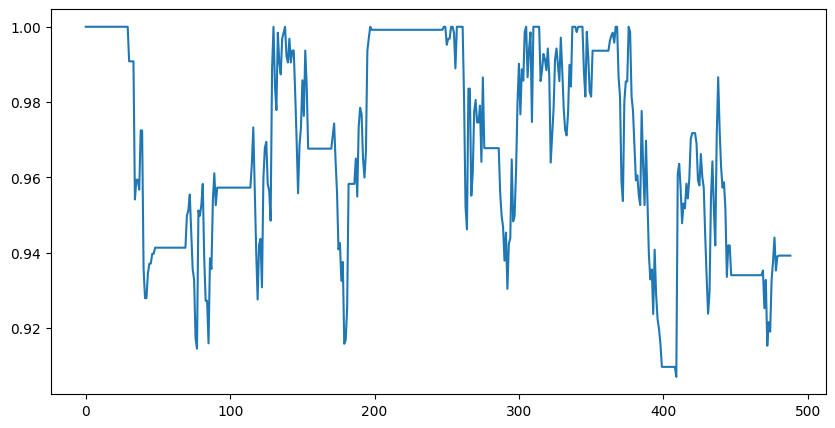

------------------------------------------------


In [18]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


### 4) 벤치마크와의 비교

총 수익률: 4.34%
------------------------------------------------
총 백테스팅 기간: 1.96년
연 수익률: 2.20%
------------------------------------------------
일 수익률: 0.01%, 일 변동성: 0.01%
Sharpe ratio: 0.10
------------------------------------------------
MDD: -32.19%


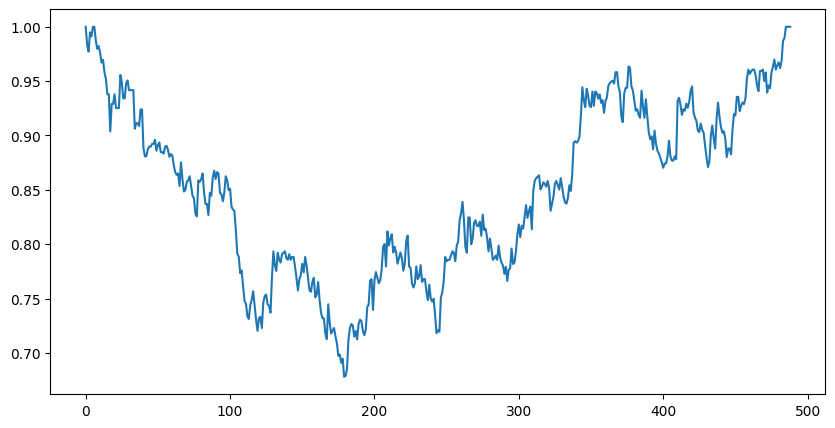

------------------------------------------------


In [19]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = df_test['close'].values/df_test['close'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')
